# **Recognition of constellations in images of the night sky**

### This project aims to recognize constellations in images of the night sky, using digital image processing thecniques.

### **Step-by-step:**

 - Image Segmentation using a threshold, making the stars appear white and the rest of the image as black (binary image);
 - Clustering: recognizing clusters of white pixels (those are the stars!);
 - Recognizing the three brightest stars;
 - Draw a triangle whose vertices are those three brightest stars;
 - Caculate the inner angles of the triangle;
 - Compare those angles to those in a database.



In [23]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import morphology, measure
from math import *
import math
import argparse
import imutils
from imutils import contours
import argparse
import imutils
import cv2

In [24]:
def thresholding(f, L):
    # create a new image with zeros
    f_tr = np.ones(f.shape).astype(np.uint8)
    # setting to 1 the pixels above the threshold
    f_tr[np.where(f < L)] = 0
    return f_tr


def normalization(g):
    g = (((g - g.min())* 255)/(g.max() - g.min()))
    return g

#still deciding a method to define the threshold, here we though about a method using the mean and log 
def Limit(img):
    return 10/np.log(255-np.mean(img))*np.mean(image1)
     

### Opening images and applying the threshold, generating a binary image as the output

Text(0.5, 1.0, 'thresholded image')

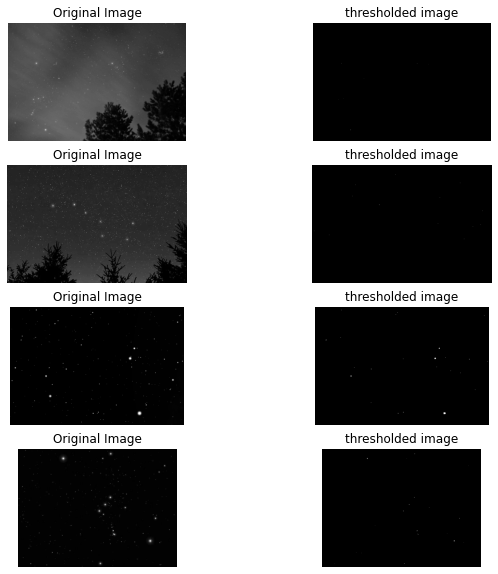

In [48]:
image1 = imageio.imread('Images/Orion/photo1.jpg', as_gray=True)
image2 = imageio.imread('Images/Ursa_Major/the-big-dipper.jpg', as_gray=True)
image3 = imageio.imread('Images/Cancer/con_CNC_001.png', as_gray=True)
image4 = imageio.imread('Images/Orion/Orion-07db06a.jpg', as_gray=True)
image5 = imageio.imread('Images/Orion/Orion-Betelgeuse.jpg', as_gray=True)

L = 240

#L = Limit(image1)
img_o1 = thresholding(image1,L)


#L = Limit(image2)
img_o2 = thresholding(image2,L)


#L = Limit(image3)
img_o3 = thresholding(image3,L)


#L = Limit(image4)
img_o4 = thresholding(image4,L)


#L = Limit(image5)
img_o5 = thresholding(image5,L)


plt.figure(figsize=(10,10))
plt.subplot(421); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(422); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(423); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(424); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(425); plt.imshow(image3, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(426); plt.imshow(img_o3, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(427); plt.imshow(image4, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(428); plt.imshow(img_o4, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

The function bellow draws a line between two points in a matrix

In [7]:
def draw_line(mat, x0, y0, x1, y1, inplace=False):
    
    if not (0 <= x0 < mat.shape[0] and 0 <= x1 < mat.shape[0] and
            0 <= y0 < mat.shape[1] and 0 <= y1 < mat.shape[1]):
        raise ValueError('Invalid coordinates.')
        
    if not inplace:
        mat = mat.copy()
        
    if (x0, y0) == (x1, y1):
        mat[x0, y0] = 1
        return mat if not inplace else None
    
    # Swap axes if Y slope is smaller than X slope
    transpose = abs(x1 - x0) < abs(y1 - y0)
    if transpose:
        mat = mat.T
        x0, y0, x1, y1 = y0, x0, y1, x1
        
    # Swap line direction to go left-to-right if necessary
    if x0 > x1:
        x0, y0, x1, y1 = x1, y1, x0, y0
        
    # Write line ends
    mat[x0, y0] = 1
    mat[x1, y1] = 1
    
    # Compute intermediate coordinates using line equation
    x = np.arange(x0 + 1, x1)
    y = np.round(((y1 - y0) / (x1 - x0)) * (x - x0) + y0).astype(x.dtype)
    
    # Write intermediate coordinates
    mat[x, y] = 1
    mat[x+1, y] = 1
    mat[x-1, y] = 1
    mat[x, y+1] = 1
    mat[x, y-1] = 1
    mat[x+1, y+1] = 1
    mat[x-1, y-1] = 1
    
    if not inplace:
        return mat if not transpose else mat.T

The functions bellow recognize clusters of stars

In [42]:
def getAndRemoveNeighboors(curPixelPos, whitePixels, pixelsToBeProcessed, pixelCluster):          
        neighboors = {(curPixelPos[0]-1, curPixelPos[1]-1), (curPixelPos[0]-1, curPixelPos[1]), (curPixelPos[0]-1, curPixelPos[1]+1),
                      (curPixelPos[0], curPixelPos[1]-1),   (curPixelPos[0], curPixelPos[1]),   (curPixelPos[0], curPixelPos[1]+1),
                      (curPixelPos[0]+1, curPixelPos[1]-1), (curPixelPos[0]+1, curPixelPos[1]), (curPixelPos[0]+1, curPixelPos[1]+1)
                     }
        
        if (pixelCluster.count(curPixelPos) == 0):
            pixelCluster.append(curPixelPos)
            
        for p in neighboors:
            if p in whitePixels:
                pixelsToBeProcessed.append(p)
                pixelCluster.append(p)
                whitePixels.remove(p)
        
        return whitePixels, pixelsToBeProcessed, pixelCluster

# retorna grupos de pixels brancos adjacentes
def clustering(img):
    whitePixels = set()
    recognizedClusters = []
    
    n, m = img.shape
    for x in range(n):
        for y in range(m):
            if (img[x,y] == 1):
                whitePixels.add(tuple([x,y]))
                
    while (len(whitePixels) != 0):
        pixelCluster = []
        pixelsToBeProcessed = []
        
        p = whitePixels.pop()
        pixelsToBeProcessed.append(p)
        
        while (len(pixelsToBeProcessed) != 0):
            curPixel = pixelsToBeProcessed[0]
            whitePixels, pixelsToBeProcessed, pixelCluster = getAndRemoveNeighboors(curPixel, whitePixels, pixelsToBeProcessed, pixelCluster)
            pixelsToBeProcessed.remove(curPixel)
    
        recognizedClusters.append(pixelCluster)
    
    return recognizedClusters

Finds the brightest spots in an image

In [37]:
def brightest_spots():
    
    # load the image, convert it to grayscale, and blur it
    image = cv2.imread("Images/Orion/Orion-07db06a.jpg")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)
    
    # threshold the image to reveal light regions in the
    # blurred image
    thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)[1]
    
    # perform a series of erosions and dilations to remove
    # any small blobs of noise from the thresholded image
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    # perform a connected component analysis on the thresholded
    # image, then initialize a mask to store only the "large"
    # components
    labels = measure.label(thresh, neighbors=8, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")
    
    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue
            
    # otherwise, construct the label mask and count the
    # number of pixels 
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
    
    # if the number of pixels in the component is sufficiently
    # large, then add it to our mask of "large blobs"
    if numPixels > 300:
        mask = cv2.add(mask, labelMask)
        
    # find the contours in the mask, then sort them from left to right
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = contours.sort_contours(cnts)[0]
    # loop over the contours
    for (i, c) in enumerate(cnts):
        # draw the bright spot on the image
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        cv2.circle(image, (int(cX), int(cY)), int(radius),(0, 0, 255), 3)
        cv2.putText(image, "#{}".format(i + 1), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    # show the output image
    cv2.imshow("Image", image)
    cv2.waitKey(0)

Functions that calculate the angle between two points

In [ ]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else: 
        return ang_deg
    
    
def slope(x1, y1, x2, y2): # Line slope given two points:
    return (y2-y1)/(x2-x1)

def angleee(s1, s2): 
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

### We will now test the functions for different constellations:

## Orion Constellation:

    

[11.767476156866817, 27.865005006653806, 39.63248116352062]


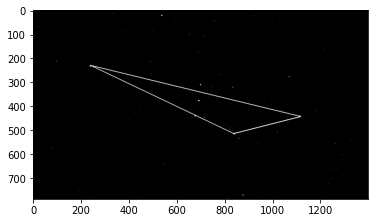

In [49]:
S = clustering(img_o5)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(img_o5, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

#emp1 = angle(stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
#emp2 = angle(stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
#1 = abs(temp2 - temp1)

#emp1 = angle(stars[1][0][0], stars[1][0][1], stars[0][0][0], stars[0][0][1])
#temp2 = angle(stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])
#a2 = abs(temp2 - temp1)

#temp1 = angle(stars[2][0][0], stars[2][0][1], stars[0][0][0], stars[0][0][1])
#temp2 = angle(stars[2][0][0], stars[2][0][1], stars[1][0][0], stars[1][0][1])
#a3 = abs(temp2 - temp1)

lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

a1 = abs(angleee(slope1, slope2))
a2 = abs(angleee(slope1, slope3))
a3 = abs(angleee(slope3, slope2))

triangle = []
triangle.append(a1)
triangle.append(a2)
triangle.append(a3)
triangle.sort()

print(triangle)
plt.imshow(img_line, cmap="gray");

[12.507824637127804, 32.36485161798482, 44.87267625511262]


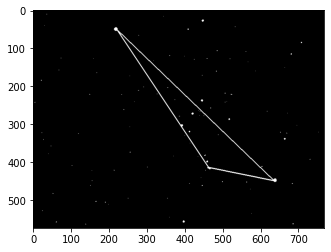

In [50]:
image4 = imageio.imread('Images/Orion/Orion-07db06a.jpg', as_gray=True)
L = Limit(image4)
img_o4 = thresholding(image4,L)

#img_o4 = morphology.binary_erosion(img_o4, morphology.star(1))
#img_o4 = morphology.binary_dilation(img_o4, morphology.star(1))
plt.imshow(img_o4, cmap="gray");

S = clustering(img_o4)
stars = sorted(S, key=len)
stars.reverse()
#print(stars)

img_line = draw_line(img_o4, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])


lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

#temp1 = angle(stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
#temp2 = angle(stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
#a1 = abs(temp2 - temp1)

#temp1 = angle(stars[1][0][0], stars[1][0][1], stars[0][0][0], stars[0][0][1])
#temp2 = angle(stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])
#a2 = abs(temp2 - temp1)

#temp1 = angle(stars[2][0][0], stars[2][0][1], stars[0][0][0], stars[0][0][1])
#temp2 = angle(stars[2][0][0], stars[2][0][1], stars[1][0][0], stars[1][0][1])
#a3 = abs(temp2 - temp1)

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

a1 = abs(angleee(slope1, slope2))
a2 = abs(angleee(slope1, slope3))
a3 = abs(angleee(slope3, slope2))

triangle = []
triangle.append(a1)
triangle.append(a2)
triangle.append(a3)
triangle.sort()

print(triangle)
plt.imshow(img_line, cmap="gray");

## Constelação Ursa Minor:

Text(0.5, 1.0, 'thresholded image')

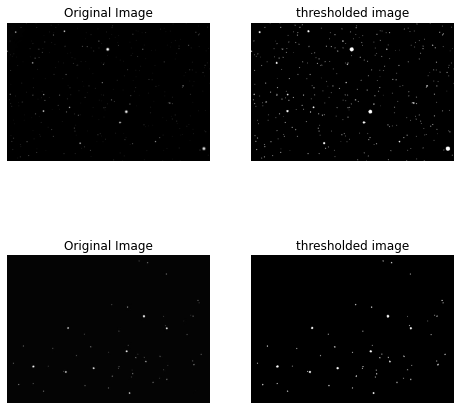

In [51]:
image1 = imageio.imread('Images/UrsaMinor/con_UMI_001.png', as_gray=True)
image2 = imageio.imread('Images/UrsaMinor/unnamed.jpg', as_gray=True)

L = Limit(image1)
img_o1 = thresholding(image1,L)

L = Limit(image2)
img_o2 = thresholding(image2,L)

plt.figure(figsize=(8,8))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[20.492175295749327, 28.289965182940698, 48.782140478690025]


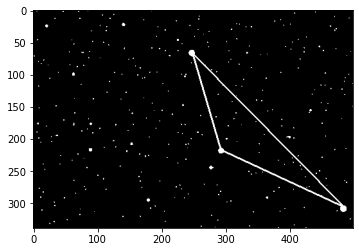

In [52]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(img_o1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

a1 = abs(angleee(slope1, slope2))
a2 = abs(angleee(slope1, slope3))
a3 = abs(angleee(slope3, slope2))

triangle = []
triangle.append(a1)
triangle.append(a2)
triangle.append(a3)
triangle.sort()

print(triangle)
plt.imshow(img_line, cmap="gray");

[22.07872232154386, 26.07218264821002, 48.15090496975388]


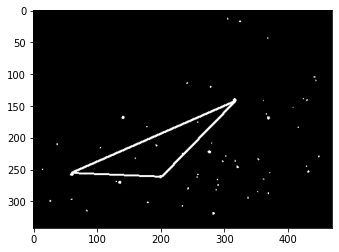

In [53]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(img_o2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

a1 = abs(angleee(slope1, slope2))
a2 = abs(angleee(slope1, slope3))
a3 = abs(angleee(slope3, slope2))

triangle = []
triangle.append(a1)
triangle.append(a2)
triangle.append(a3)
triangle.sort()

print(triangle)
plt.imshow(img_line, cmap="gray");

## Ursa Major:

Text(0.5, 1.0, 'thresholded image')

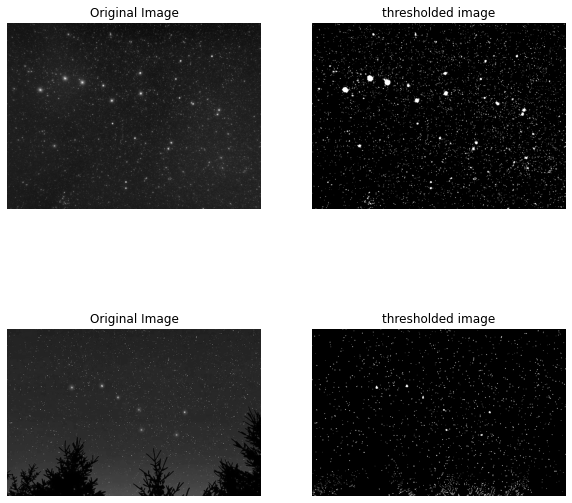

In [54]:
image1 = imageio.imread('Images/UrsaMajor/constellation-of-ursa-major-tony--daphne-hallasscience-photo-library.jpg', as_gray=True)
image2 = imageio.imread('Images/UrsaMajor/the-big-dipper.jpg', as_gray=True)

L = Limit(image1)
img_o1 = thresholding(image1,L)

L = Limit(image2)
img_o2 = thresholding(image2,80)

plt.figure(figsize=(10,10))
plt.subplot(221); plt.imshow(image1, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(222); plt.imshow(img_o1, cmap="gray"); plt.axis('off'); plt.title('thresholded image')
plt.subplot(223); plt.imshow(image2, cmap="gray"); plt.axis('off'); plt.title('Original Image')
plt.subplot(224); plt.imshow(img_o2, cmap="gray"); plt.axis('off'); plt.title('thresholded image')

[14.150758530992402, 21.737884424223605, 35.888642955216]


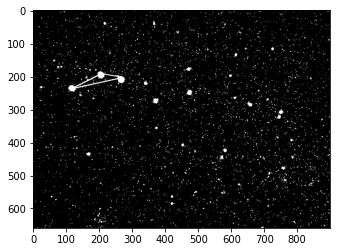

In [55]:
S = clustering(img_o1)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(img_o1, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

a1 = abs(angleee(slope1, slope2))
a2 = abs(angleee(slope1, slope3))
a3 = abs(angleee(slope3, slope2))

triangle = []
triangle.append(a1)
triangle.append(a2)
triangle.append(a3)
triangle.sort()

print(triangle)
plt.imshow(img_line, cmap="gray");

[14.09655626895118, 21.53116364603279, 35.62771991498397]


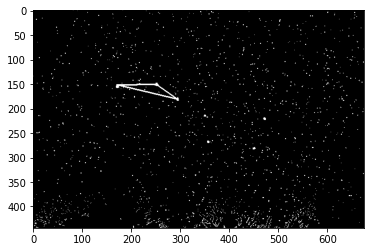

In [56]:
S = clustering(img_o2)
stars = sorted(S, key=len)
stars.reverse()

img_line = draw_line(img_o2, stars[0][0][0], stars[0][0][1], stars[1][0][0], stars[1][0][1])
img_line = draw_line(img_line, stars[0][0][0], stars[0][0][1], stars[2][0][0], stars[2][0][1])
img_line = draw_line(img_line, stars[1][0][0], stars[1][0][1], stars[2][0][0], stars[2][0][1])

lineA = ((stars[0][0][0], stars[0][0][1]), (stars[1][0][0], stars[1][0][1]))
lineB = ((stars[0][0][0], stars[0][0][1]), (stars[2][0][0], stars[2][0][1]))
lineC = ((stars[1][0][0], stars[1][0][1]), (stars[2][0][0], stars[2][0][1]))

slope1 = slope(lineA[0][0], lineA[0][1], lineA[1][0], lineA[1][1])
slope2 = slope(lineB[0][0], lineB[0][1], lineB[1][0], lineB[1][1])
slope3 = slope(lineC[0][0], lineC[0][1], lineC[1][0], lineC[1][1])

a1 = abs(angleee(slope1, slope2))
a2 = abs(angleee(slope1, slope3))
a3 = abs(angleee(slope3, slope2))

triangle = []
triangle.append(a1)
triangle.append(a2)
triangle.append(a3)
triangle.sort()

print(triangle)
plt.imshow(img_line, cmap="gray");